# Melbourne Real State - Data Integration and Reshaping

## Sebastian Guerra




Version: 1.0

Environment: Python 3 and Jupyter notebook

Libraries used:
* pandas
* datetime
* ast
* numpy
* sklearn
* networkx

### Introduction

The main goal of this project is to bring different data sources together. Obtaining information from real state house we integrate the following data into a csv file:

<br><br>-Suburb coordiantes
<br>-Suburb council
<br>-Average crime rate by type of crime
<br>-Closest schools
<br>-Rancking of closest schools
<br>-Identifying overpriced houses compared to average price
<br>-Finding closes train station with direct service to Southern Cross
<br>-Travel time to CBD


For task 2, the goal is to reshape the data to be able to visualize variables in a better way. For example log, min-max transformations and normalization.

## Importing libraries 

In [1]:
import pandas as pd
import numpy
import matplotlib 
%matplotlib inline
import shapefile
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from shapely.geometry import Point 
from shapely.geometry import Polygon
import ast
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import geopandas
import xml.etree.ElementTree as ET
from math import radians, cos, sin, asin, sqrt
from datetime import datetime, date
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import preprocessing

# Task 1: Data Integration

## Loading data

In [2]:
real_estate_df = pd.read_csv("data.csv")

real_estate_df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
0,ID951619551,1/295 Clarendon St,2,u,1360000.0,22/05/2016,1.0,2.0,0.0,129.0,-37.83350,144.96110
1,ID336146137,8/27 Kensington Rd,2,u,613000.0,26/07/2016,1.0,1.0,0.0,109.0,-37.83800,145.00110
2,ID857802811,4 Boyd St,3,h,980000.0,19/11/2016,1.0,2.0,724.0,54.0,-37.86720,144.81700
3,ID677073684,32 Hooker Rd,3,h,515000.0,23/09/2017,2.0,1.0,517.0,34.0,-37.89423,144.64131
4,ID379495600,6/26 Ruskin St,2,u,500000.0,22/05/2016,1.0,1.0,0.0,49.0,-37.87610,144.98210


## Shape File Data Exploration

Plotting the shape file data onto the map of Victoria.

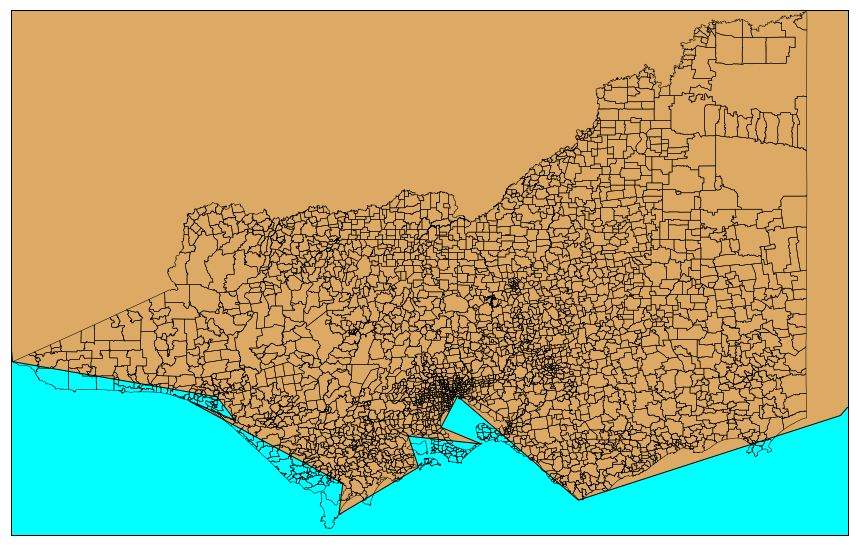

In [3]:
# Initializing a basemap object with bounds adjusted as per Victoria's bounds.
m = Basemap(projection='mill',
            llcrnrlon=150,
            urcrnrlon=140.5,
            llcrnrlat=-39.2,
            urcrnrlat=-34)

# Plotting the shape file onto the basemap projection.
plt.figure(figsize = (15,15))
m.fillcontinents(color='#ddaa66',lake_color='aqua')
m.drawmapboundary(fill_color='aqua')
m.drawcoastlines()
m.readshapefile('./VIC_LOCALITY_POLYGON_shp', 'suburb')
plt.show()

## Imputing Suburb from Co-ordinates

Identifying the suburb for each house based on its location and the polygons read from the shape files.

In [4]:
# Loading the shape file of Victoria into a dataframe using geopandas .read_file() function.
vic_locality_df = geopandas.read_file('./VIC_LOCALITY_POLYGON_shp.shp')

vic_locality_df.head()

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((141.74552399 -35.07228701, 141.74552..."
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,"POLYGON ((148.668767 -37.39571245, 148.6687620..."
2,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,"POLYGON ((142.92287999 -37.97885997, 142.90449..."
3,6673,2011-08-31,None,VIC734,2017-08-09,None,DEPTFORD,None,None,G,None,2,"POLYGON ((147.82335712 -37.66000897, 147.82312..."
4,6674,2011-08-31,None,VIC2900,2012-04-27,None,YANAC,None,None,G,None,2,"POLYGON ((141.279783 -35.99858911, 141.2798853..."


In [5]:
# Function to return the suburb name based on the latitude and longitude supplied to it.

# @input location_point: Point object containing the Latitude and Longitude of the house.
# @return: suburb name based on the location.
def impute_suburb(location_point):
    # Iterating over the read shape file dataframe.
    for i in range(len(vic_locality_df)):
        # Checking if the supplied point belongs within the Polygon of the suburb being iterated over.
        if location_point.within(vic_locality_df.geometry[i]):
            # Return the suburb name if the point belongs within the Polygon
            return vic_locality_df.VIC_LOCA_2[i]
    
    # Return "not available" if the point does not belong within any of the polygons.
    return "not available"

In [6]:
# Creating a new column "coordinates" containing a Point object of Latitude and Longitude of the house.
real_estate_df["coordinates"] = real_estate_df.apply(lambda row: Point(row["Longtitude"], row["Lattitude"]), axis=1)

# Creating a new column "Suburb" containing the suburb names fetched by supplying the Point object in "coordinates" column to impute_suburb() function
real_estate_df["Suburb"] = real_estate_df.apply(lambda row: impute_suburb(row["coordinates"]), axis=1)

real_estate_df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,coordinates,Suburb
0,ID951619551,1/295 Clarendon St,2,u,1360000.0,22/05/2016,1.0,2.0,0.0,129.0,-37.83350,144.96110,POINT (144.9611 -37.8335),SOUTH MELBOURNE
1,ID336146137,8/27 Kensington Rd,2,u,613000.0,26/07/2016,1.0,1.0,0.0,109.0,-37.83800,145.00110,POINT (145.0011 -37.838),SOUTH YARRA
2,ID857802811,4 Boyd St,3,h,980000.0,19/11/2016,1.0,2.0,724.0,54.0,-37.86720,144.81700,POINT (144.817 -37.8672),ALTONA
3,ID677073684,32 Hooker Rd,3,h,515000.0,23/09/2017,2.0,1.0,517.0,34.0,-37.89423,144.64131,POINT (144.64131 -37.89423),WERRIBEE
4,ID379495600,6/26 Ruskin St,2,u,500000.0,22/05/2016,1.0,1.0,0.0,49.0,-37.87610,144.98210,POINT (144.9821 -37.8761),ELWOOD


## Identifying the Council for each Suburb.

Extracting the council name for each suburb using the councils.txt file.

In [7]:
# Creating file pipe for reading from councils.txt
council_file_pipe = open("councils.txt", "r")

# Initializing a dict for Council and its list of suburbs.
council_dict = {}

# Iterating over each line in the councils.txt file.
for line in council_file_pipe:
    # Splitting the line around " : "
    council_data = line.split(' : ')
    # Stroring the list of suburbs for council name as key.
    council_dict[council_data[0]] = ast.literal_eval(council_data[1])

In [8]:
# Function to return the council name based on the suburb name supplied to it.

# @input suburb_name: Name of the suburb the house is in.
# @return: council name based on the suburb.
def impute_council(suburb_name):
    # Iterating over the key, value pairs in the council_dict
    for council_name, suburb_list in council_dict.items():
        # Lower casing the suburb names for comparission
        suburb_list = [suburb.lower() for suburb in suburb_list]
        
        # Checking if the suburb name supplied belongs to the council being iterated over.
        if suburb_name.lower() in suburb_list:
            # Return council name if the suburb belongs to the council being iterated over.
            return council_name
    
    # Return 'N/A' if the suburb does not belong to any of the councils.
    return 'N/A'

In [9]:
# Creating a new column for the council information based on the suburb column by calling the impute_council function.
real_estate_df["Council"] = real_estate_df.apply(lambda row: impute_council(row["Suburb"]), axis=1)

In [10]:
real_estate_df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,coordinates,Suburb,Council
0,ID951619551,1/295 Clarendon St,2,u,1360000.0,22/05/2016,1.0,2.0,0.0,129.0,-37.83350,144.96110,POINT (144.9611 -37.8335),SOUTH MELBOURNE,GREATER SHEPPARTON
1,ID336146137,8/27 Kensington Rd,2,u,613000.0,26/07/2016,1.0,1.0,0.0,109.0,-37.83800,145.00110,POINT (145.0011 -37.838),SOUTH YARRA,GREATER SHEPPARTON
2,ID857802811,4 Boyd St,3,h,980000.0,19/11/2016,1.0,2.0,724.0,54.0,-37.86720,144.81700,POINT (144.817 -37.8672),ALTONA,BRIMBANK
3,ID677073684,32 Hooker Rd,3,h,515000.0,23/09/2017,2.0,1.0,517.0,34.0,-37.89423,144.64131,POINT (144.64131 -37.89423),WERRIBEE,LODDON
4,ID379495600,6/26 Ruskin St,2,u,500000.0,22/05/2016,1.0,1.0,0.0,49.0,-37.87610,144.98210,POINT (144.9821 -37.8761),ELWOOD,MORELAND


## Calculating the crime average in each suburb based on crime type.

In [11]:
# Reading the excel file using the .read_excel() function available within pandas
crime_data_df = pd.read_excel("crimebylocationdatatable-yearending31march2016.xlsx", sheet_name="Table 1")

# Filtering out the useless rows and columns from the read excel file data.
crime_data_df = crime_data_df.iloc[17:, 1:]
crime_data_df = crime_data_df.reset_index(drop=True)
# Setting the first row as the column headers.
crime_data_df.columns = crime_data_df.iloc[0]
# Dropping the first row from the dataframe.
crime_data_df = crime_data_df.iloc[1:]
crime_data_df = crime_data_df.reset_index(drop=True)

crime_data_df.head()

,Apr - Mar reference period,Police Region,Police Service Area,Local Government Area,CSA Offence Division,CSA Offence Subdivision,Offence Count,LGA ERP,Victorian ERP
0,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A10 Homicide and related offences,4,123600,5632521
1,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A20 Assault and related offences,568,123600,5632521
2,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A30 Sexual offences,132,123600,5632521
3,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A40 Abduction and related offences,12,123600,5632521
4,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A50 Robbery,46,123600,5632521


In [12]:
# Converting all the numeric columns to their relevant object type columns.
crime_data_df = crime_data_df.convert_objects(convert_numeric = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [13]:
# Preparing the data for the calculation of average crime counts based on crime type and year.

# Extracting the crime type into a new column "Crime Type"
crime_data_df["Crime Type"] = crime_data_df["CSA Offence Division"].apply(lambda x: x[0])

# Extracting the year from the date column into a new column "Year"
real_estate_df["Year"] = real_estate_df.apply(lambda row: int(row["Date"][-4:]), axis=1)

In [14]:
# Function to return the crime average based on the council name, year and the crime type supplied to it.

# @input council_name: Name of the council the house is in.
# @input year: Year the house was sold in.
# @input crime_type: Crime type.
# @return: average crime rate of crime type supplied in the last 3 years before the house was bought in its council.
def impute_crime_average(council_name, year, crime_type):
    # Initializing a list of last 3 years before the year that is supplied.
    last_three_years = list(range(year-3, year))
    # Converting each year to string.
    last_three_years = [str(yr) for yr in last_three_years]
    
    # Creating a filtered dataframe based on the council name, last 3 years and crime type.
    filtered_crime_data_df = crime_data_df[(crime_data_df["Local Government Area"] == council_name) & \
                                            (crime_data_df["Apr - Mar reference period"].isin(last_three_years)) & \
                                            (crime_data_df["Crime Type"] == crime_type)]
    
    # Calculating the average of the offence count over the filtered dataframe.
    average_crime = filtered_crime_data_df["Offence Count"].mean()
    
    # Rounding the value of average crime to 2 decimal places and returning it.
    return round(average_crime, 2)

In [15]:
# Creating columns for the average of each crime type by using the impute_crime_average() function.
real_estate_df["crime_A_average"] = real_estate_df.apply(lambda row: impute_crime_average(row["Council"], row["Year"], "A"), axis=1)
real_estate_df["crime_B_average"] = real_estate_df.apply(lambda row: impute_crime_average(row["Council"], row["Year"], "B"), axis=1)
real_estate_df["crime_C_average"] = real_estate_df.apply(lambda row: impute_crime_average(row["Council"], row["Year"], "C"), axis=1)

In [16]:
real_estate_df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,coordinates,Suburb,Council,Year,crime_A_average,crime_B_average,crime_C_average
0,ID951619551,1/295 Clarendon St,2,u,1360000.0,22/05/2016,1.0,2.0,0.0,129.0,-37.83350,144.96110,POINT (144.9611 -37.8335),SOUTH MELBOURNE,GREATER SHEPPARTON,2016,137.58,681.81,137.20
1,ID336146137,8/27 Kensington Rd,2,u,613000.0,26/07/2016,1.0,1.0,0.0,109.0,-37.83800,145.00110,POINT (145.0011 -37.838),SOUTH YARRA,GREATER SHEPPARTON,2016,137.58,681.81,137.20
2,ID857802811,4 Boyd St,3,h,980000.0,19/11/2016,1.0,2.0,724.0,54.0,-37.86720,144.81700,POINT (144.817 -37.8672),ALTONA,BRIMBANK,2016,311.21,2215.75,346.00
3,ID677073684,32 Hooker Rd,3,h,515000.0,23/09/2017,2.0,1.0,517.0,34.0,-37.89423,144.64131,POINT (144.64131 -37.89423),WERRIBEE,LODDON,2017,18.50,38.13,6.33
4,ID379495600,6/26 Ruskin St,2,u,500000.0,22/05/2016,1.0,1.0,0.0,49.0,-37.87610,144.98210,POINT (144.9821 -37.8761),ELWOOD,MORELAND,2016,195.83,1779.07,147.30


## Identifying the closest primary and secondary schools.

In [17]:
# Class to bundle the School information into a single object.
class School:
    
    # Overriding the init function to define a constructor for School object.
    def __init__(self, school_no, school_name, school_type, latitude, longitude):
        self.school_no = school_no
        self.school_name = school_name
        self.school_type = school_type
        self.latitude = latitude
        self.longitude = longitude

In [18]:
# Parsing the schools.xml into a tree object.
tree = ET.parse('schools.xml')

# Initializing a list of School objects.
schools = list()

# Initializing School objects using infotmation extracted from the xml tree and appending it to the list of schools.
for elem in tree.findall('school'):
    schools.append(School(elem.find('School_No').text, elem.find('School_Name').text, elem.find('School_Type').text, float(elem.find('Y').text), float(elem.find('X').text)))

In [19]:
# Filtering the school objects in the list based on the school type (Primary/Secondary).
primary_schools = list()
secondary_schools = list()
for school in schools:
    if school.school_type == "Primary":
        primary_schools.append(school)
    elif school.school_type == "Secondary":
        secondary_schools.append(school)
    elif school.school_type == "Pri/Sec":
        primary_schools.append(school)
        secondary_schools.append(school)

In [20]:
# https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6378 # Radius of earth in kilometers. Use 3956 for miles
    return (c * r) * 1000

In [21]:
# Function to return the name of the nearest primary school and the shortest distance to the school based on the location.

# @input latitude: Latitude of the house.
# @input longitude: Longitude of the house.
# @return: tuple of school name and the shortest distance to it.
def get_closest_primary_school(latitude, longitude):
    # Initializing dummy values for the closest primary school and shortest distance to the school.
    closest_primary_school = None
    shortest_distance_to_school = -1
    
    # Iterating over each primary school in the list.
    for school in primary_schools:
        # Calculating the distance to the school being iterated over.
        calculated_distance = haversine(longitude, latitude, school.longitude, school.latitude)
        # Comparing the shortest distance to the school until this point to the new calculated value.
        if shortest_distance_to_school == -1 or shortest_distance_to_school > calculated_distance:
            # Reassigning the closest school value and the shortest distance to school value if the calculated distance is shorter.
            closest_primary_school = school
            shortest_distance_to_school = calculated_distance
    
    # Returning a tuple of school name and the distance to the school.
    return (closest_primary_school.school_name, round(shortest_distance_to_school, 2))

In [22]:
# Creating new columns "closest_primary_school" and "distance_to_closest_primary" with the values returned from the get_closest_primary_school() function for each row.
real_estate_df["closest_primary_school"] = real_estate_df.apply(lambda row: get_closest_primary_school(row["Lattitude"], row["Longtitude"])[0], axis=1)
real_estate_df["distance_to_closest_primary"] = real_estate_df.apply(lambda row: get_closest_primary_school(row["Lattitude"], row["Longtitude"])[1], axis=1)

In [23]:
# Function to return the name of the nearest secondary school and the shortest distance to the school based on the location.

# @input latitude: Latitude of the house.
# @input longitude: Longitude of the house.
# @return: tuple of school name and the shortest distance to it.
def get_closest_secondary_school(latitude, longitude):
    # Initializing dummy values for the closest secondary school and shortest distance to the school.
    closest_secondary_school = None
    shortest_distance_to_school = -1
    
    # Iterating over each secondary school in the list.
    for school in secondary_schools:
        # Calculating the distance to the school being iterated over.
        calculated_distance = haversine(longitude, latitude, school.longitude, school.latitude)
        # Comparing the shortest distance to the school until this point to the new calculated value.
        if shortest_distance_to_school == -1 or shortest_distance_to_school > calculated_distance:
            # Reassigning the closest school value and the shortest distance to school value if the calculated distance is shorter.
            closest_secondary_school = school
            shortest_distance_to_school = calculated_distance
    
    # Returning a tuple of school name and the distance to the school.
    return (closest_secondary_school.school_name, round(shortest_distance_to_school, 2))

In [24]:
# Creating new columns "closest_secondary_school" and "distance_to_closest_secondary" with the values returned from the get_closest_secondary_school() function for each row.
real_estate_df["closest_secondary_school"] = real_estate_df.apply(lambda row: get_closest_secondary_school(row["Lattitude"], row["Longtitude"])[0], axis=1)
real_estate_df["distance_to_closest_secondary"] = real_estate_df.apply(lambda row: get_closest_secondary_school(row["Lattitude"], row["Longtitude"])[1], axis=1)

## Extracting the ranking for each primary and secondary school in the dataframe.

In [25]:
# Initializing a dictionary of schools and their rankings.
primary_school_rankings = {}

# Loading the html response from the website and initializing a beautiful soup object.
html = urlopen("http://www.schoolcatchment.com.au/?p=12301")
bsobj = BeautifulSoup(html, "lxml")

# Searching for all the table rows 
table_rows = bsobj.find("tbody", {"class":"row-hover"}).findAll("tr")

for row in table_rows:
    # Initializing dummy values for rank and name of each school
    rank = -1
    name = ""
    
    # Iterating over each of the tds found inside each tr of the tbody.
    for column in row.findAll("td"):
        if "class" in column.attrs:
            if "column-1" in column.attrs["class"]:
                # Storing the td value as rank if it has a class "column-1"
                rank = column.text
            elif "column-2" in column.attrs["class"]:
                # Storing the td value as name if it has a class "column-2"
                name = column.text
    
    # Storing the ranks with names as key.
    primary_school_rankings[name] = rank

In [26]:
# Function to return the rank of the school based on its name.

# @input school_name: Name of the school.
# @return: rank of the school.
def get_primary_school_rank(school_name):
    if school_name in primary_school_rankings:
        # Returning the rank value if the school name exists as a key in the dict.
        return primary_school_rankings[school_name]
    else:
        # Returning "not ranked" for schools not in the dict.
        return "not ranked"

In [27]:
# Creating a new column "primary_school_ranking" based on the values returned from the get_primary_school_rank() function.
real_estate_df["primary_school_ranking"] = real_estate_df.apply(lambda row: get_primary_school_rank(row["closest_primary_school"]), axis=1)

In [28]:
# Initializing a dictionary of schools and their rankings.
secondary_school_rankings = {}

# Loading the html response from the website and initializing a beautiful soup object.
bsobj = BeautifulSoup(open("secondary-school-ranking.html"), "html.parser")

# Searching for all the li items 
list_rows = bsobj.find("ul", {"class":None, "role":None}).findAll("li")

for row in list_rows:
    # Initializing dummy values for rank and name of each school
    rank = -1
    name = ""
    
    # Iterating over each of the div found inside each li of the ul.
    for idx, div in enumerate(row.findAll('div')):
        if idx == 0:
            # Storing the div value as name if its at index 0
            name = div.text
        elif idx == 1:
            # Storing the div value as name if its at index 1
            rank = div.text
    
    # Storing the ranks with names as key.
    secondary_school_rankings[name] = rank

In [29]:
# Function to return the rank of the school based on its name.

# @input school_name: Name of the school.
# @return: rank of the school.
def get_secondary_school_rank(school_name):
    if school_name in secondary_school_rankings:
        # Returning the rank value if the school name exists as a key in the dict.
        return secondary_school_rankings[school_name]
    else:
        # Returning "not ranked" for schools not in the dict.
        return "not ranked"

In [30]:
# Creating a new column "secondary_school_ranking" based on the values returned from the get_secondary_school_rank() function.
real_estate_df["secondary_school_ranking"] = real_estate_df.apply(lambda row: get_secondary_school_rank(row["closest_secondary_school"]), axis=1)

In [31]:
real_estate_df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,Year,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,closest_secondary_school,distance_to_closest_secondary,primary_school_ranking,secondary_school_ranking
0,ID951619551,1/295 Clarendon St,2,u,1360000.0,22/05/2016,1.0,2.0,0.0,129.0,...,2016,137.58,681.81,137.20,Galilee Regional Catholic Primary School,627.10,Victorian College Of The Arts Secondary School,669.50,208,not ranked
1,ID336146137,8/27 Kensington Rd,2,u,613000.0,26/07/2016,1.0,1.0,0.0,109.0,...,2016,137.58,681.81,137.20,Richmond Primary School,955.27,Melbourne High School,525.10,260,2
2,ID857802811,4 Boyd St,3,h,980000.0,19/11/2016,1.0,2.0,724.0,54.0,...,2016,311.21,2215.75,346.00,Altona Primary School,507.75,Mount St Joseph Girls' College,594.85,213,119
3,ID677073684,32 Hooker Rd,3,h,515000.0,23/09/2017,2.0,1.0,517.0,34.0,...,2017,18.50,38.13,6.33,Manorvale Primary School,227.61,Wyndham Central Secondary College,1249.55,not ranked,not ranked
4,ID379495600,6/26 Ruskin St,2,u,500000.0,22/05/2016,1.0,1.0,0.0,49.0,...,2016,195.83,1779.07,147.30,Yesodei HaTorah College,342.37,Yesodei HaTorah College,342.37,277,38


## Identifying if the house was overpriced (over the median cost).

In [32]:
# Function to return the rank of the school based on its name.

# @input bedroom_count: Number of rooms in the house.
# @input bathroom_count: Number of bathrooms in the house.
# @input parking_space: Number of car spaces in the house.
# @input property_type: Type of the property.
# @input price: Listed price of the house.
# @return: if the house was overpriced.
def impute_is_overpriced(bedroom_count, bathroom_count, parking_space, property_type, price):
    # Filtering the dataframe based on the room count, bathroom count, car space count and house type.
    filtered_real_estate_df = real_estate_df[(real_estate_df["Rooms"] == bedroom_count) & \
                                             (real_estate_df["Bathroom"] == bathroom_count) & \
                                             (real_estate_df["Car"] == parking_space) & \
                                             (real_estate_df["Type"] == property_type)]
    
    # Calculating the median of the house price in the filtered dataframe.
    median_price = filtered_real_estate_df["Price"].median()
    
    # Checking if the price of the house is greater than the median price.
    if price > median_price:
        # Return True if price of house is more than median price.
        return True
    else:
        # Return False if price of house is less than or equal to median price.
        return False

In [33]:
real_estate_df["over_priced?"] = real_estate_df.apply(lambda row: impute_is_overpriced(row["Rooms"], row["Bathroom"], row["Car"], row["Type"], row["Price"]), axis=1)

In [34]:
real_estate_df.head(10)

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,closest_secondary_school,distance_to_closest_secondary,primary_school_ranking,secondary_school_ranking,over_priced?
0,ID951619551,1/295 Clarendon St,2,u,1360000.0,22/05/2016,1.0,2.0,0.0,129.0,...,137.58,681.81,137.20,Galilee Regional Catholic Primary School,627.10,Victorian College Of The Arts Secondary School,669.50,208,not ranked,True
1,ID336146137,8/27 Kensington Rd,2,u,613000.0,26/07/2016,1.0,1.0,0.0,109.0,...,137.58,681.81,137.20,Richmond Primary School,955.27,Melbourne High School,525.10,260,2,True
2,ID857802811,4 Boyd St,3,h,980000.0,19/11/2016,1.0,2.0,724.0,54.0,...,311.21,2215.75,346.00,Altona Primary School,507.75,Mount St Joseph Girls' College,594.85,213,119,True
3,ID677073684,32 Hooker Rd,3,h,515000.0,23/09/2017,2.0,1.0,517.0,34.0,...,18.50,38.13,6.33,Manorvale Primary School,227.61,Wyndham Central Secondary College,1249.55,not ranked,not ranked,False
4,ID379495600,6/26 Ruskin St,2,u,500000.0,22/05/2016,1.0,1.0,0.0,49.0,...,195.83,1779.07,147.30,Yesodei HaTorah College,342.37,Yesodei HaTorah College,342.37,277,38,False
5,ID816586480,303/62 Altona St,1,u,355000.0,8/04/2017,1.0,1.0,2581.0,39.0,...,41.14,142.40,25.22,Holy Rosary School,326.63,Kensington Community High School,1115.13,437,not ranked,True
6,ID904481708,1/42 Wattle Dr,3,h,582000.0,8/10/2016,1.0,0.0,302.0,69.0,...,79.68,512.19,63.50,Macleod College,1023.09,Macleod College,1023.09,not ranked,459,False
7,ID710660600,5 Lockheed St,4,h,950000.0,22/05/2016,3.0,2.0,541.0,53.0,...,121.09,439.20,60.44,Glenroy West Primary School,1518.89,Glenroy Secondary College,2708.25,not ranked,511,False
8,ID967698177,138 Raleigh St,2,h,1143000.0,22/08/2016,1.0,2.0,431.0,49.0,...,300.46,919.82,195.56,Wales Street Primary School,190.37,Santa Maria College,1300.03,175,137,True
9,ID906083657,11/201 Wellington Pde S,1,u,630000.0,25/02/2017,1.0,1.0,0.0,49.0,...,20.27,47.56,11.00,Richmond West Primary School,1539.15,Holmes Secondary College,918.08,452,277,True


## Finding the Train Station ID to nearest station having a direct trip to South Bank

In [35]:
# Extracting and reading all gtf assets.
import zipfile
for file in range(1,3):
    extract=zipfile.ZipFile('gtfs/'+str(file)+'/google_transit.zip',"r")
    extract.extractall('gtfs/'+str(file)+'/google_transit')
    if file ==1:
        agency= pd.read_csv('gtfs/'+str(file)+'/google_transit/agency.txt')
        calendar= pd.read_csv('gtfs/'+str(file)+'/google_transit/calendar.txt')
        calendar_dates= pd.read_csv('gtfs/'+str(file)+'/google_transit/calendar_dates.txt')
        routes= pd.read_csv('gtfs/'+str(file)+'/google_transit/routes.txt')
        shapes= pd.read_csv('gtfs/'+str(file)+'/google_transit/shapes.txt')
        stop_times= pd.read_csv('gtfs/'+str(file)+'/google_transit/stop_times.txt')
        stops= pd.read_csv('gtfs/'+str(file)+'/google_transit/stops.txt')
        trips= pd.read_csv('gtfs/'+str(file)+'/google_transit/trips.txt')
    else:
        agency= agency.append(pd.read_csv('gtfs/'+str(file)+'/google_transit/agency.txt'))
        calendar= calendar.append(pd.read_csv('gtfs/'+str(file)+'/google_transit/calendar.txt'))
        calendar_dates= calendar_dates.append(pd.read_csv('gtfs/'+str(file)+'/google_transit/calendar_dates.txt'))
        routes= routes.append(pd.read_csv('gtfs/'+str(file)+'/google_transit/routes.txt'))
        shapes= shapes.append(pd.read_csv('gtfs/'+str(file)+'/google_transit/shapes.txt'))
        stop_times= stop_times.append(pd.read_csv('gtfs/'+str(file)+'/google_transit/stop_times.txt'))
        stops= stops.append(pd.read_csv('gtfs/'+str(file)+'/google_transit/stops.txt'))
        trips= trips.append(pd.read_csv('gtfs/'+str(file)+'/google_transit/trips.txt'))

In [36]:
# Filtering trip_ids based on whether it has South Bank as a stop.
trip_ids_for_trips_direct_to_south_bank = list(set(stop_times[((stop_times["stop_id"] == 20043) | (stop_times["stop_id"] == 22180))]["trip_id"]))

# Getting a list of all service ids which run on weekdays.
service_ids_running_on_weekdays = list(set(calendar[((calendar['monday'] == 1) & (calendar['tuesday'] == 1) & (calendar['wednesday'] == 1) & (calendar['thursday'] == 1) & (calendar['friday'] == 1))]["service_id"]))

# Getting a list of trip ids possible on weekdays.
possible_trip_ids_on_weekdays = list(set(trips[trips['service_id'].isin(service_ids_running_on_weekdays)]["trip_id"]))

# Filtering out trip ids which do not have a stop on South Bank.
possible_trip_ids_direct_to_south_bank = [trip_id for trip_id in possible_trip_ids_on_weekdays if trip_id in trip_ids_for_trips_direct_to_south_bank]

In [37]:
# Filtering for the trip ids on weekdays which have direct train to south bank.
possible_stop_times_weekday = stop_times[stop_times["trip_id"].isin(possible_trip_ids_direct_to_south_bank)].copy()

# Filtering in all stop ids except South Bank.
possible_stop_times_departure = possible_stop_times_weekday[((possible_stop_times_weekday["stop_id"] != 20043) & (possible_stop_times_weekday["stop_id"] != 22180))].copy()

# Filtering in all South Bank trip instances.
possible_stop_times_arrival = possible_stop_times_weekday[((possible_stop_times_weekday["stop_id"] == 20043) | (possible_stop_times_weekday["stop_id"] == 22180))].copy()

In [38]:
# Function to return formatted time.
def fix_time(raw_time):
    try:
        return datetime.strptime(raw_time, "%H:%M:%S").time()
    except:
        return datetime.strptime('00' + raw_time[2:], "%H:%M:%S").time()

In [39]:
# Formatting string departure_time to time object.
possible_stop_times_departure["departure_time"] = possible_stop_times_departure.apply(lambda row: fix_time(row["departure_time"]), axis=1)

# Formatting string arrival_time to time object.
possible_stop_times_arrival["arrival_time"] = possible_stop_times_arrival.apply(lambda row: fix_time(row["arrival_time"]), axis=1)

In [40]:
# Filtering in all morning departures (7-9:30 am)
possible_stop_times_departure_timed = possible_stop_times_departure[((possible_stop_times_departure["departure_time"] > datetime.strptime("07:00:00", "%H:%M:%S").time())\
                                                              & (possible_stop_times_departure["departure_time"] < datetime.strptime("09:30:00", "%H:%M:%S").time()))].copy()

In [41]:
trip_ids_and_stop_ids = possible_stop_times_departure_timed[["trip_id", "stop_id"]].copy()

# Getting a list of stops grouped by trip id.
trip_ids_and_stop_ids_series = trip_ids_and_stop_ids.groupby("trip_id").stop_id.apply(list)

In [42]:
# Getting a list of trips running in the morning.
trip_ids_in_morning = list(set(possible_stop_times_departure_timed["trip_id"]))

# Filtering in the arrival instances for each of the morning trips.
possible_stop_times_arrival = possible_stop_times_arrival[(possible_stop_times_arrival["trip_id"].isin(trip_ids_in_morning))]

In [43]:
# Function to identify if the train is coming from south bank or goinf to south bank.
def filter_out_outgoing_from_south_bank(trip_id, departure_time):
    departure_time = fix_time(departure_time)
    
    filtered_arrival_df = possible_stop_times_arrival[(possible_stop_times_arrival["trip_id"] == trip_id)]
    
    # Extracting the arrival time.
    arrival_time = list(filtered_arrival_df["arrival_time"])[0]
    
    if arrival_time < departure_time:
        return 1
    
    return 0

In [44]:
# Filtering out trips which do not have South Bank as a stop.
possible_trips_to_south_bank = stop_times[(stop_times["trip_id"].isin(trip_ids_in_morning))].copy()

# Identifying the trips heading towards southbank and filtering them in.
possible_trips_to_south_bank["filter"] = possible_trips_to_south_bank.apply(lambda row: filter_out_outgoing_from_south_bank(row["trip_id"], row["departure_time"]), axis=1)

# Dropping all trips coming from south bank
possible_trips_to_south_bank = possible_trips_to_south_bank[(possible_trips_to_south_bank["filter"] == 0)]

# Dropping the extra column.
possible_trips_to_south_bank = possible_trips_to_south_bank.drop("filter", axis=1)

In [45]:
# Getting a list of possible station ids.
possible_station_ids = list(set(possible_trips_to_south_bank["stop_id"]))

# Filtering out the stops which do not have a direct train to South Bank.
possible_stops = stops[(stops["stop_id"].isin(possible_station_ids))].copy()

In [46]:
# Function to return the name of the nearest train station id and the shortest distance to the train station based on the location.

# @input latitude: Latitude of the house.
# @input longitude: Longitude of the house.
# @return: tuple of train station id and the shortest distance to it.
def get_closest_train_station(latitude, longitude):
    # Initializing dummy values for the closest secondary school and shortest distance to the school.
    closest_train_station = None
    shortest_distance_to_train_station = -1
    
    # Iterating over each stop in the list.
    for idx, row in possible_stops.iterrows():
        # Calculating the distance to the stop being iterated over.
        calculated_distance = haversine(longitude, latitude, row["stop_lon"], row["stop_lat"])
        # Comparing the shortest distance to the stop until this point to the new calculated value.
        if shortest_distance_to_train_station == -1 or shortest_distance_to_train_station > calculated_distance:
            # Reassigning the closest stop value and the shortest distance to stop value if the calculated distance is shorter.
            closest_train_station = row["stop_id"]
            shortest_distance_to_train_station = calculated_distance
    
    # Returning a tuple of stop id and the distance to the school.
    return (closest_train_station, round(shortest_distance_to_train_station, 2))

In [47]:
# Creating new columns "train_station_id" and "distance_to_train_station" with the values returned from the get_closest_train_station() function for each row.
real_estate_df["train_station_id"] = real_estate_df.apply(lambda row: get_closest_train_station(row["Lattitude"], row["Longtitude"])[0], axis=1)
real_estate_df["distance_to_train_station"] = real_estate_df.apply(lambda row: get_closest_train_station(row["Lattitude"], row["Longtitude"])[1], axis=1)

In [48]:
real_estate_df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,crime_C_average,closest_primary_school,distance_to_closest_primary,closest_secondary_school,distance_to_closest_secondary,primary_school_ranking,secondary_school_ranking,over_priced?,train_station_id,distance_to_train_station
0,ID951619551,1/295 Clarendon St,2,u,1360000.0,22/05/2016,1.0,2.0,0.0,129.0,...,137.20,Galilee Regional Catholic Primary School,627.10,Victorian College Of The Arts Secondary School,669.50,208,not ranked,True,22238,1768.30
1,ID336146137,8/27 Kensington Rd,2,u,613000.0,26/07/2016,1.0,1.0,0.0,109.0,...,137.20,Richmond Primary School,955.27,Melbourne High School,525.10,260,2,True,19947,739.37
2,ID857802811,4 Boyd St,3,h,980000.0,19/11/2016,1.0,2.0,724.0,54.0,...,346.00,Altona Primary School,507.75,Mount St Joseph Girls' College,594.85,213,119,True,19925,382.55
3,ID677073684,32 Hooker Rd,3,h,515000.0,23/09/2017,2.0,1.0,517.0,34.0,...,6.33,Manorvale Primary School,227.61,Wyndham Central Secondary College,1249.55,not ranked,not ranked,False,19921,1831.92
4,ID379495600,6/26 Ruskin St,2,u,500000.0,22/05/2016,1.0,1.0,0.0,49.0,...,147.30,Yesodei HaTorah College,342.37,Yesodei HaTorah College,342.37,277,38,False,19955,1154.47


## Finding the travel time to CBD from the closest train station.

In [49]:
# Function to return the average travel time to CBD from the station.

# @input station_id: station id.
# @return: average travel time in mins.
def get_average_travel_time(station_id):
    travel_times = []
    
    for trip_id in trip_ids_in_morning:
        # Checking if the station can be on the trip being iterated over.
        if station_id in trip_ids_and_stop_ids_series[trip_id]:
            # Filtering in the departure_time instance from station for the trip being iterated over.
            departure_time_df = possible_stop_times_departure_timed[((possible_stop_times_departure_timed["stop_id"] == station_id)\
                                                                      &(possible_stop_times_departure_timed["trip_id"] == trip_id))]
            
            
            # Extracting the departure time.
            departure_time = list(departure_time_df["departure_time"])[0]
            
             # Filtering in the arrival_time instance from station for the trip being iterated over.
            arrival_time_df = possible_stop_times_arrival[(possible_stop_times_arrival["trip_id"] == trip_id)]
            
            # Extracting the arrival time.
            arrival_time = list(arrival_time_df["arrival_time"])[0]
            
            # Calculating the time taken between stations.
            time_taken = datetime.combine(date.today(), arrival_time) - datetime.combine(date.today(), departure_time)
            
            # Converting and appending the time taken in mins if the time taken was positive.
            if time_taken.total_seconds() > 0:
                travel_times.append(time_taken.total_seconds() / 60.0)
    
    # Returning the average time taken to complete journey.
    if(len(travel_times) > 0):
        return round(sum(travel_times) / len(travel_times), 2)
    
    return 0

In [50]:
# Creating a new column "travel_min_to_CBD" using the values calculated in the get_average_travel_time() function.
real_estate_df["travel_min_to_CBD"] = real_estate_df.apply(lambda row: get_average_travel_time(row["train_station_id"]), axis=1)

In [51]:
real_estate_df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,closest_primary_school,distance_to_closest_primary,closest_secondary_school,distance_to_closest_secondary,primary_school_ranking,secondary_school_ranking,over_priced?,train_station_id,distance_to_train_station,travel_min_to_CBD
0,ID951619551,1/295 Clarendon St,2,u,1360000.0,22/05/2016,1.0,2.0,0.0,129.0,...,Galilee Regional Catholic Primary School,627.10,Victorian College Of The Arts Secondary School,669.50,208,not ranked,True,22238,1768.30,3.50
1,ID336146137,8/27 Kensington Rd,2,u,613000.0,26/07/2016,1.0,1.0,0.0,109.0,...,Richmond Primary School,955.27,Melbourne High School,525.10,260,2,True,19947,739.37,16.21
2,ID857802811,4 Boyd St,3,h,980000.0,19/11/2016,1.0,2.0,724.0,54.0,...,Altona Primary School,507.75,Mount St Joseph Girls' College,594.85,213,119,True,19925,382.55,28.50
3,ID677073684,32 Hooker Rd,3,h,515000.0,23/09/2017,2.0,1.0,517.0,34.0,...,Manorvale Primary School,227.61,Wyndham Central Secondary College,1249.55,not ranked,not ranked,False,19921,1831.92,35.14
4,ID379495600,6/26 Ruskin St,2,u,500000.0,22/05/2016,1.0,1.0,0.0,49.0,...,Yesodei HaTorah College,342.37,Yesodei HaTorah College,342.37,277,38,False,19955,1154.47,19.50


In [52]:
real_estate_df = real_estate_df[["ID", "Address", "Suburb", "Price",\
                                 "Type", "Date", "Rooms", "Bathroom",\
                                 "Car", "Landsize", "Age", "Lattitude",\
                                 "Longtitude", "train_station_id", "distance_to_train_station", "travel_min_to_CBD",\
                                 "over_priced?", "crime_A_average", "crime_B_average", "crime_C_average",\
                                 "closest_primary_school", "distance_to_closest_primary", "primary_school_ranking",\
                                 "closest_secondary_school", "distance_to_closest_secondary", "secondary_school_ranking"]]

real_estate_df.rename(columns={'Landsize':'LandSize',
                               'Lattitude':'Latitude',
                               'Longtitude':'Longitude'},
                      inplace=True)

real_estate_df.to_csv('solution.csv', sep=',', encoding='utf-8',index=False)

# Task 2: Data Reshaping

In [53]:
# Initializing a dataframe with necessary columns.
real_estate_df_reshape = real_estate_df[["Rooms", "crime_C_average", "travel_min_to_CBD", "Age", "Price"]].copy()

In [54]:
real_estate_df_reshape.describe()

,Rooms,crime_C_average,travel_min_to_CBD,Age,Price
count,720.000000,720.000000,720.000000,720.000000,7.200000e+02
mean,2.904167,135.804250,25.423972,54.643056,1.066413e+06
std,1.056398,112.588021,10.878063,35.999406,6.761970e+05
min,1.000000,1.000000,0.000000,2.000000,1.850000e+05
25%,2.000000,53.002500,18.157500,20.750000,6.380000e+05
50%,3.000000,111.670000,25.885000,49.000000,9.300000e+05
75%,3.000000,184.670000,32.000000,79.000000,1.325250e+06
max,10.000000,557.000000,68.820000,139.000000,8.000000e+06


In [55]:
# Building a model and testing its accuracy.
features_df = real_estate_df_reshape[["Rooms", "crime_C_average", "travel_min_to_CBD", "Age"]].copy()
target_df = real_estate_df_reshape[["Price"]].copy()

training_x, testing_x, training_y, testing_y = train_test_split(features_df, target_df , test_size=0.3, random_state=212)

lm_price_of_house = LinearRegression()

lm_price_of_house.fit(training_x, training_y)

print("R square value for model:", lm_price_of_house.score(testing_x, testing_y))

R square value for model: 0.3171400584133611


## Z-score Normalisation (standardisation):

In [56]:
# Standardising each row.
std_scale = preprocessing.StandardScaler().fit(real_estate_df_reshape[["Rooms", "crime_C_average", "travel_min_to_CBD", "Age"]])
df_std = std_scale.transform(real_estate_df_reshape[["Rooms", "crime_C_average", "travel_min_to_CBD", "Age"]]) # an array not a df
df_std[0:5]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[-0.85649072,  0.01240559, -2.01683087,  2.06694062],
       [-0.85649072,  0.01240559, -0.84761208,  1.51098969],
       [ 0.09078012,  1.86824379,  0.28297006, -0.01787537],
       [ 0.09078012, -1.1507819 ,  0.89379719, -0.5738263 ],
       [-0.85649072,  0.10217554, -0.54495827, -0.1568631 ]])

In [57]:
# Assigning values to dataframe columns.
real_estate_df_reshape["RoomScaled"] = df_std[:, 0]
real_estate_df_reshape["crime_C_averageScaled"] = df_std[:, 1]
real_estate_df_reshape["travel_min_to_CBDScaled"] = df_std[:, 2]
real_estate_df_reshape["AgeScaled"] = df_std[:, 3]

In [58]:
real_estate_df_reshape.describe()

,Rooms,crime_C_average,travel_min_to_CBD,Age,Price,RoomScaled,crime_C_averageScaled,travel_min_to_CBDScaled,AgeScaled
count,720.000000,720.000000,720.000000,720.000000,7.200000e+02,7.200000e+02,7.200000e+02,7.200000e+02,7.200000e+02
mean,2.904167,135.804250,25.423972,54.643056,1.066413e+06,-2.222374e-16,-8.326673e-18,-3.282868e-16,6.283554e-17
std,1.056398,112.588021,10.878063,35.999406,6.761970e+05,1.000695e+00,1.000695e+00,1.000695e+00,1.000695e+00
min,1.000000,1.000000,0.000000,2.000000,1.850000e+05,-1.803762e+00,-1.198156e+00,-2.338803e+00,-1.463348e+00
25%,2.000000,53.002500,18.157500,20.750000,6.380000e+05,-8.564907e-01,-7.359514e-01,-6.684576e-01,-9.421438e-01
50%,3.000000,111.670000,25.885000,49.000000,9.300000e+05,9.078012e-02,-2.145080e-01,4.241088e-02,-1.568631e-01
75%,3.000000,184.670000,32.000000,79.000000,1.325250e+06,9.078012e-02,4.343244e-01,6.049422e-01,6.770633e-01
max,10.000000,557.000000,68.820000,139.000000,8.000000e+06,6.721676e+00,3.743636e+00,3.992089e+00,2.344916e+00


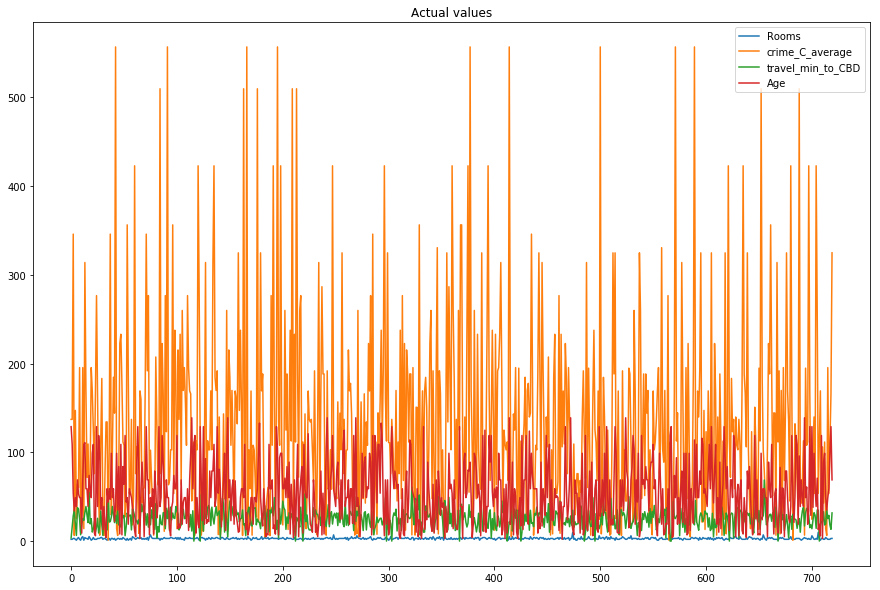

In [59]:
# Plotting values of non-standardised columns.
plt.figure(figsize=(15,10))
real_estate_df_reshape["Rooms"].plot(), real_estate_df_reshape["crime_C_average"].plot(), real_estate_df_reshape["travel_min_to_CBD"].plot(), real_estate_df_reshape["Age"].plot()
plt.legend(["Rooms","crime_C_average","travel_min_to_CBD","Age"])
plt.title("Actual values")
plt.show()

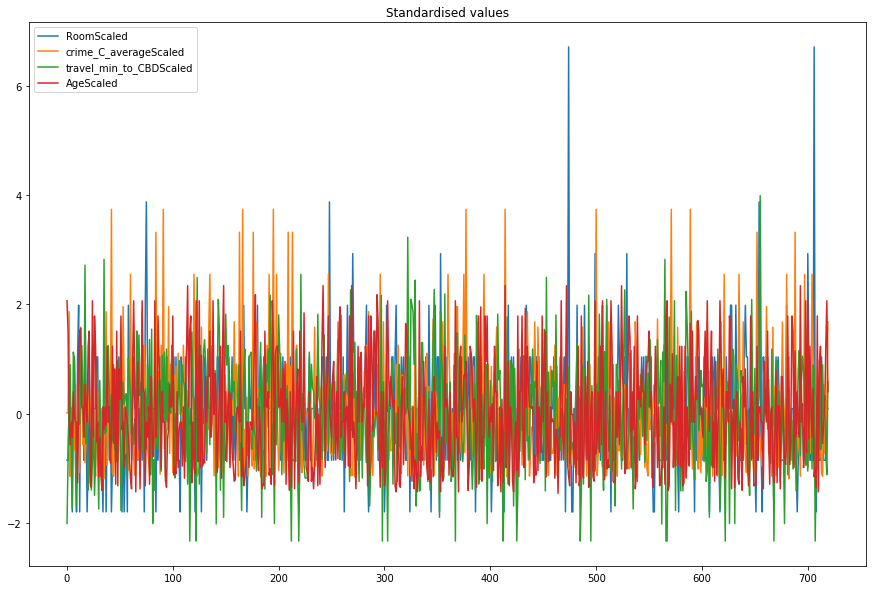

In [60]:
# Plotting the scaled columns.
plt.figure(figsize=(15,10))
real_estate_df_reshape["RoomScaled"].plot(), real_estate_df_reshape["crime_C_averageScaled"].plot(), real_estate_df_reshape["travel_min_to_CBDScaled"].plot(), real_estate_df_reshape["AgeScaled"].plot()
plt.legend(["RoomScaled","crime_C_averageScaled","travel_min_to_CBDScaled","AgeScaled"])
plt.title("Standardised values")
plt.show()

In [61]:
# Calculating the accuracy of model with scaled values.
features_df = real_estate_df_reshape[["RoomScaled", "crime_C_averageScaled", "travel_min_to_CBDScaled", "AgeScaled"]].copy()
target_df = real_estate_df_reshape[["Price"]].copy()

training_x, testing_x, training_y, testing_y = train_test_split(features_df, target_df , test_size=0.3, random_state=212)

lm_price_of_house_scaled = LinearRegression()

lm_price_of_house_scaled.fit(training_x, training_y)

print("R square value for model:", lm_price_of_house_scaled.score(testing_x, testing_y))

R square value for model: 0.317140058413361


## Min-Max Transformation:

In [62]:
# Applying min-max scaling to values.
minmax_scale = preprocessing.MinMaxScaler().fit(real_estate_df_reshape[["Rooms", "crime_C_average", "travel_min_to_CBD", "Age"]])
df_minmax = minmax_scale.transform(real_estate_df_reshape[["Rooms", "crime_C_average", "travel_min_to_CBD", "Age"]])
df_minmax[0:5]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


array([[0.11111111, 0.24496403, 0.05085731, 0.9270073 ],
       [0.11111111, 0.24496403, 0.23554199, 0.7810219 ],
       [0.22222222, 0.6205036 , 0.4141238 , 0.37956204],
       [0.22222222, 0.00958633, 0.51060738, 0.23357664],
       [0.11111111, 0.2631295 , 0.28334786, 0.34306569]])

In [63]:
# Assigning values to dataframe columns.
real_estate_df_reshape["RoomMinMax"] = df_minmax[:, 0]
real_estate_df_reshape["crime_C_averageMinMax"] = df_minmax[:, 1]
real_estate_df_reshape["travel_min_to_CBDMinMax"] = df_minmax[:, 2]
real_estate_df_reshape["AgeMinMax"] = df_minmax[:, 3]

In [64]:
real_estate_df_reshape.describe()

,Rooms,crime_C_average,travel_min_to_CBD,Age,Price,RoomScaled,crime_C_averageScaled,travel_min_to_CBDScaled,AgeScaled,RoomMinMax,crime_C_averageMinMax,travel_min_to_CBDMinMax,AgeMinMax
count,720.000000,720.000000,720.000000,720.000000,7.200000e+02,7.200000e+02,7.200000e+02,7.200000e+02,7.200000e+02,720.000000,720.000000,720.000000,720.000000
mean,2.904167,135.804250,25.423972,54.643056,1.066413e+06,-2.222374e-16,-8.326673e-18,-3.282868e-16,6.283554e-17,0.211574,0.242454,0.369427,0.384256
std,1.056398,112.588021,10.878063,35.999406,6.761970e+05,1.000695e+00,1.000695e+00,1.000695e+00,1.000695e+00,0.117378,0.202496,0.158065,0.262769
min,1.000000,1.000000,0.000000,2.000000,1.850000e+05,-1.803762e+00,-1.198156e+00,-2.338803e+00,-1.463348e+00,0.000000,0.000000,0.000000,0.000000
25%,2.000000,53.002500,18.157500,20.750000,6.380000e+05,-8.564907e-01,-7.359514e-01,-6.684576e-01,-9.421438e-01,0.111111,0.093530,0.263840,0.136861
50%,3.000000,111.670000,25.885000,49.000000,9.300000e+05,9.078012e-02,-2.145080e-01,4.241088e-02,-1.568631e-01,0.222222,0.199047,0.376126,0.343066
75%,3.000000,184.670000,32.000000,79.000000,1.325250e+06,9.078012e-02,4.343244e-01,6.049422e-01,6.770633e-01,0.222222,0.330342,0.464981,0.562044
max,10.000000,557.000000,68.820000,139.000000,8.000000e+06,6.721676e+00,3.743636e+00,3.992089e+00,2.344916e+00,1.000000,1.000000,1.000000,1.000000


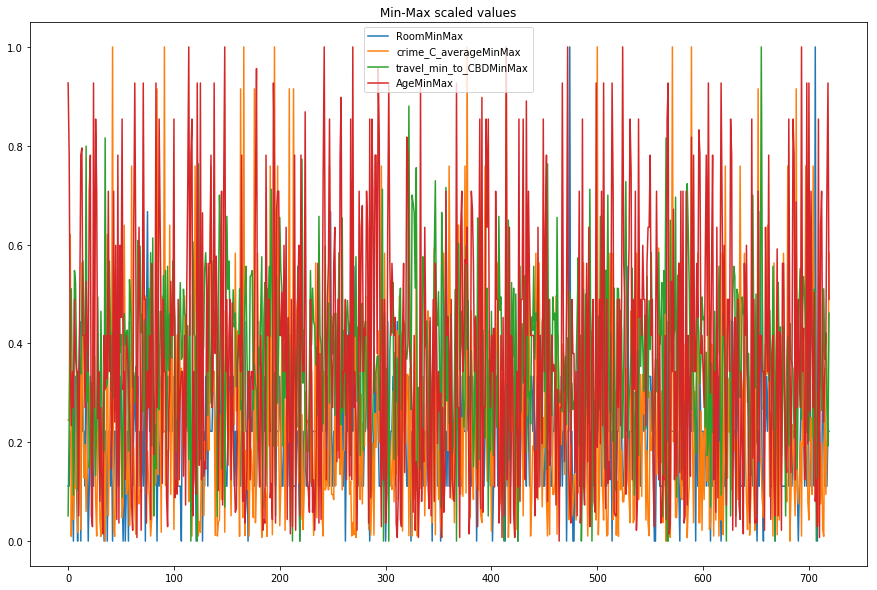

In [65]:
# Plotting scaled values.
plt.figure(figsize=(15,10))
real_estate_df_reshape["RoomMinMax"].plot(), real_estate_df_reshape["crime_C_averageMinMax"].plot(), real_estate_df_reshape["travel_min_to_CBDMinMax"].plot(), real_estate_df_reshape["AgeMinMax"].plot()
plt.legend(["RoomMinMax","crime_C_averageMinMax","travel_min_to_CBDMinMax","AgeMinMax"])
plt.title("Min-Max scaled values")
plt.show()

In [66]:
# Calculating the accuracy of model with scaled values.
features_df = real_estate_df_reshape[["RoomMinMax", "crime_C_averageMinMax", "travel_min_to_CBDMinMax", "AgeMinMax"]].copy()
target_df = real_estate_df_reshape[["Price"]].copy()

training_x, testing_x, training_y, testing_y = train_test_split(features_df, target_df , test_size=0.3, random_state=212)

lm_price_of_house_min_max = LinearRegression()

lm_price_of_house_min_max.fit(training_x, training_y)

print("R square value for model:", lm_price_of_house_min_max.score(testing_x, testing_y))

R square value for model: 0.3171400584133611


## Data Transformation:

### Root Transformation

In [67]:
import math

# Taking roots of each value
i = 0
for row in real_estate_df_reshape.iterrows():
    real_estate_df_reshape.at[i,'RoomsRoot']=math.sqrt(real_estate_df_reshape["Rooms"][i]) 
    i += 1

i = 0
for row in real_estate_df_reshape.iterrows():
    real_estate_df_reshape.at[i,'crime_C_averageRoot']=math.sqrt(real_estate_df_reshape["crime_C_average"][i]) 
    i += 1
    
i = 0
for row in real_estate_df_reshape.iterrows():
    real_estate_df_reshape.at[i,'travel_min_to_CBDRoot']=math.sqrt(real_estate_df_reshape["travel_min_to_CBD"][i]) 
    i += 1
    
i = 0
for row in real_estate_df_reshape.iterrows():
    real_estate_df_reshape.at[i,'AgeRoot']=math.sqrt(real_estate_df_reshape["Age"][i]) 
    i += 1

In [68]:
real_estate_df_reshape.head()

,Rooms,crime_C_average,travel_min_to_CBD,Age,Price,RoomScaled,crime_C_averageScaled,travel_min_to_CBDScaled,AgeScaled,RoomMinMax,crime_C_averageMinMax,travel_min_to_CBDMinMax,AgeMinMax,RoomsRoot,crime_C_averageRoot,travel_min_to_CBDRoot,AgeRoot
0,2,137.20,3.50,129.0,1360000.0,-0.856491,0.012406,-2.016831,2.066941,0.111111,0.244964,0.050857,0.927007,1.414214,11.713240,1.870829,11.357817
1,2,137.20,16.21,109.0,613000.0,-0.856491,0.012406,-0.847612,1.510990,0.111111,0.244964,0.235542,0.781022,1.414214,11.713240,4.026164,10.440307
2,3,346.00,28.50,54.0,980000.0,0.090780,1.868244,0.282970,-0.017875,0.222222,0.620504,0.414124,0.379562,1.732051,18.601075,5.338539,7.348469
3,3,6.33,35.14,34.0,515000.0,0.090780,-1.150782,0.893797,-0.573826,0.222222,0.009586,0.510607,0.233577,1.732051,2.515949,5.927900,5.830952
4,2,147.30,19.50,49.0,500000.0,-0.856491,0.102176,-0.544958,-0.156863,0.111111,0.263129,0.283348,0.343066,1.414214,12.136721,4.415880,7.000000


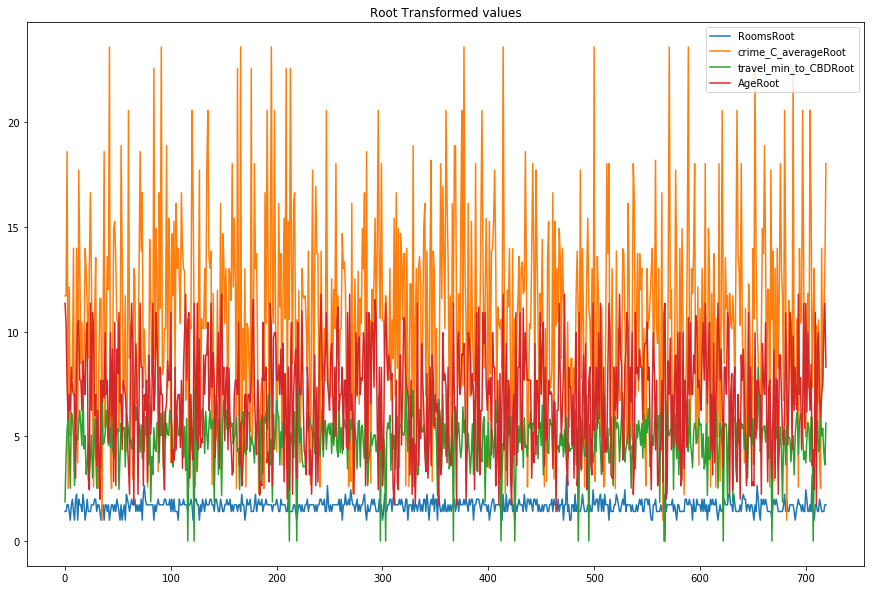

In [69]:
# Plotting the root transformed values
plt.figure(figsize=(15,10))
real_estate_df_reshape["RoomsRoot"].plot(), real_estate_df_reshape["crime_C_averageRoot"].plot(), real_estate_df_reshape["travel_min_to_CBDRoot"].plot(), real_estate_df_reshape["AgeRoot"].plot()
plt.legend(["RoomsRoot","crime_C_averageRoot","travel_min_to_CBDRoot","AgeRoot"])
plt.title("Root Transformed values")
plt.show()

In [70]:
# Calculating the accuracy of model with root transformed values.
features_df = real_estate_df_reshape[["RoomsRoot", "crime_C_averageRoot", "travel_min_to_CBDRoot", "AgeRoot"]].copy()
target_df = real_estate_df_reshape[["Price"]].copy()

training_x, testing_x, training_y, testing_y = train_test_split(features_df, target_df , test_size=0.3, random_state=212)

lm_price_of_house_root = LinearRegression()

lm_price_of_house_root.fit(training_x, training_y)

print("R square value for model:", lm_price_of_house_root.score(testing_x, testing_y))

R square value for model: 0.3283836768402762


### Square power Transformation

In [71]:
# Calculating square powers of values.
i = 0
for row in real_estate_df_reshape.iterrows():
    real_estate_df_reshape.at[i,'RoomsPow']=math.pow(real_estate_df_reshape["Rooms"][i], 2) 
    i += 1

i = 0
for row in real_estate_df_reshape.iterrows():
    real_estate_df_reshape.at[i,'crime_C_averagePow']=math.pow(real_estate_df_reshape["crime_C_average"][i], 2) 
    i += 1
    
i = 0
for row in real_estate_df_reshape.iterrows():
    real_estate_df_reshape.at[i,'travel_min_to_CBDPow']=math.pow(real_estate_df_reshape["travel_min_to_CBD"][i], 2) 
    i += 1
    
i = 0
for row in real_estate_df_reshape.iterrows():
    real_estate_df_reshape.at[i,'AgePow']=math.pow(real_estate_df_reshape["Age"][i], 2) 
    i += 1

In [72]:
real_estate_df_reshape.head()

,Rooms,crime_C_average,travel_min_to_CBD,Age,Price,RoomScaled,crime_C_averageScaled,travel_min_to_CBDScaled,AgeScaled,RoomMinMax,...,travel_min_to_CBDMinMax,AgeMinMax,RoomsRoot,crime_C_averageRoot,travel_min_to_CBDRoot,AgeRoot,RoomsPow,crime_C_averagePow,travel_min_to_CBDPow,AgePow
0,2,137.20,3.50,129.0,1360000.0,-0.856491,0.012406,-2.016831,2.066941,0.111111,...,0.050857,0.927007,1.414214,11.713240,1.870829,11.357817,4.0,18823.8400,12.2500,16641.0
1,2,137.20,16.21,109.0,613000.0,-0.856491,0.012406,-0.847612,1.510990,0.111111,...,0.235542,0.781022,1.414214,11.713240,4.026164,10.440307,4.0,18823.8400,262.7641,11881.0
2,3,346.00,28.50,54.0,980000.0,0.090780,1.868244,0.282970,-0.017875,0.222222,...,0.414124,0.379562,1.732051,18.601075,5.338539,7.348469,9.0,119716.0000,812.2500,2916.0
3,3,6.33,35.14,34.0,515000.0,0.090780,-1.150782,0.893797,-0.573826,0.222222,...,0.510607,0.233577,1.732051,2.515949,5.927900,5.830952,9.0,40.0689,1234.8196,1156.0
4,2,147.30,19.50,49.0,500000.0,-0.856491,0.102176,-0.544958,-0.156863,0.111111,...,0.283348,0.343066,1.414214,12.136721,4.415880,7.000000,4.0,21697.2900,380.2500,2401.0


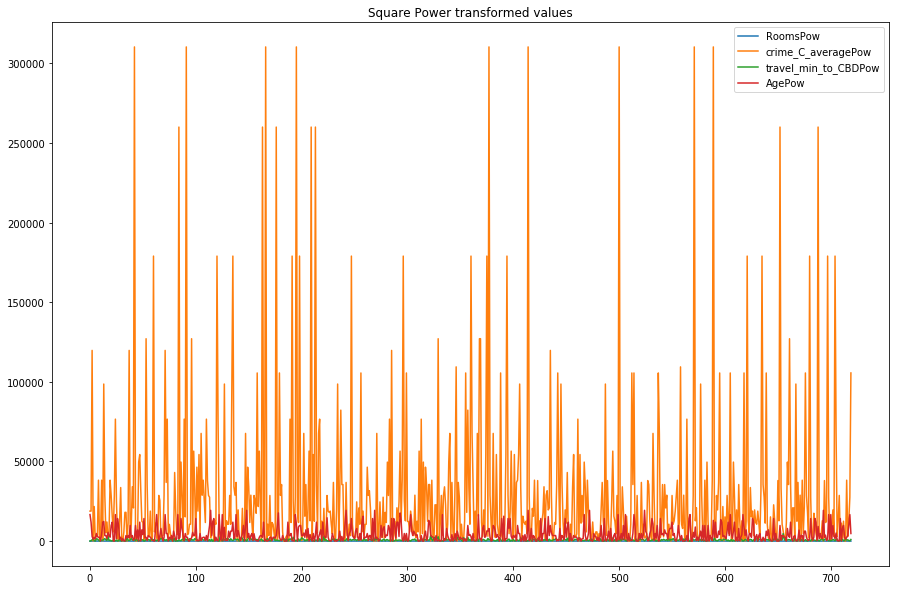

In [73]:
# Plotting square powers of values.
plt.figure(figsize=(15,10))
real_estate_df_reshape["RoomsPow"].plot(), real_estate_df_reshape["crime_C_averagePow"].plot(), real_estate_df_reshape["travel_min_to_CBDPow"].plot(), real_estate_df_reshape["AgePow"].plot()
plt.legend(["RoomsPow","crime_C_averagePow","travel_min_to_CBDPow","AgePow"])
plt.title("Square Power transformed values")
plt.show()

In [74]:
# Calculating the accuracy of model with square powered values.
features_df = real_estate_df_reshape[["RoomsPow", "crime_C_averagePow", "travel_min_to_CBDPow", "AgePow"]].copy()
target_df = real_estate_df_reshape[["Price"]].copy()

training_x, testing_x, training_y, testing_y = train_test_split(features_df, target_df , test_size=0.3, random_state=212)

lm_price_of_house_pow = LinearRegression()

lm_price_of_house_pow.fit(training_x, training_y)

print("R square value for model:", lm_price_of_house_pow.score(testing_x, testing_y))

R square value for model: 0.20762834131342


### Log Transformation

In [75]:
# Taking log values for each column.
i = 0
for row in real_estate_df_reshape.iterrows():
    real_estate_df_reshape.at[i,'RoomsLog']=math.log(real_estate_df_reshape["Rooms"][i]) 
    i += 1

i = 0
for row in real_estate_df_reshape.iterrows():
    real_estate_df_reshape.at[i,'crime_C_averageLog']=math.log(real_estate_df_reshape["crime_C_average"][i]) 
    i += 1
    
i = 0
for row in real_estate_df_reshape.iterrows():
    try:
        real_estate_df_reshape.at[i,'travel_min_to_CBDLog']=math.log(real_estate_df_reshape["travel_min_to_CBD"][i]) 
    except:
        real_estate_df_reshape.at[i,'travel_min_to_CBDLog']=0
    i += 1
    
i = 0
for row in real_estate_df_reshape.iterrows():
    real_estate_df_reshape.at[i,'AgeLog']=math.log(real_estate_df_reshape["Age"][i]) 
    i += 1

In [76]:
real_estate_df_reshape.head()

,Rooms,crime_C_average,travel_min_to_CBD,Age,Price,RoomScaled,crime_C_averageScaled,travel_min_to_CBDScaled,AgeScaled,RoomMinMax,...,travel_min_to_CBDRoot,AgeRoot,RoomsPow,crime_C_averagePow,travel_min_to_CBDPow,AgePow,RoomsLog,crime_C_averageLog,travel_min_to_CBDLog,AgeLog
0,2,137.20,3.50,129.0,1360000.0,-0.856491,0.012406,-2.016831,2.066941,0.111111,...,1.870829,11.357817,4.0,18823.8400,12.2500,16641.0,0.693147,4.921440,1.252763,4.859812
1,2,137.20,16.21,109.0,613000.0,-0.856491,0.012406,-0.847612,1.510990,0.111111,...,4.026164,10.440307,4.0,18823.8400,262.7641,11881.0,0.693147,4.921440,2.785628,4.691348
2,3,346.00,28.50,54.0,980000.0,0.090780,1.868244,0.282970,-0.017875,0.222222,...,5.338539,7.348469,9.0,119716.0000,812.2500,2916.0,1.098612,5.846439,3.349904,3.988984
3,3,6.33,35.14,34.0,515000.0,0.090780,-1.150782,0.893797,-0.573826,0.222222,...,5.927900,5.830952,9.0,40.0689,1234.8196,1156.0,1.098612,1.845300,3.559340,3.526361
4,2,147.30,19.50,49.0,500000.0,-0.856491,0.102176,-0.544958,-0.156863,0.111111,...,4.415880,7.000000,4.0,21697.2900,380.2500,2401.0,0.693147,4.992471,2.970414,3.891820


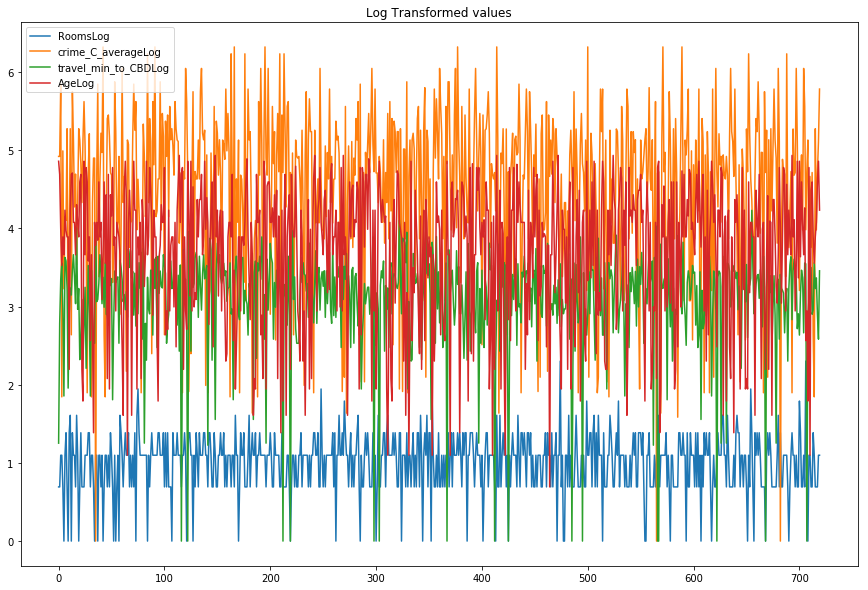

In [77]:
# Plotting log transformed values
plt.figure(figsize=(15,10))
real_estate_df_reshape["RoomsLog"].plot(), real_estate_df_reshape["crime_C_averageLog"].plot(), real_estate_df_reshape["travel_min_to_CBDLog"].plot(), real_estate_df_reshape["AgeLog"].plot()
plt.legend(["RoomsLog","crime_C_averageLog","travel_min_to_CBDLog","AgeLog"])
plt.title("Log Transformed values")
plt.show()

In [78]:
# Calculating the accuracy of model with log transformed values.
features_df = real_estate_df_reshape[["RoomsLog", "crime_C_averageLog", "travel_min_to_CBDLog", "AgeLog"]].copy()
target_df = real_estate_df_reshape[["Price"]].copy()

training_x, testing_x, training_y, testing_y = train_test_split(features_df, target_df , test_size=0.3, random_state=212)

lm_price_of_house_log = LinearRegression()

lm_price_of_house_log.fit(training_x, training_y)

print("R square value for model:", lm_price_of_house_log.score(testing_x, testing_y))

R square value for model: 0.302070515304414


As evident from the above transformations, log transformation is not a valid choice since we have 0 values in the travel_mins_to_CBD column. After accessing the accuracy scores for the root transformation and the square power transformation, it is evident that the root transformation is the better choice here since it gives a much higher accuracy than power transformation and also has a higher accuracy than the normal models.

The square root transformation is also a good idea because of the huge difference in the ranges of different columns and so square root values normalize the dataset and mitigate distances instead of enlarging them.